In [1]:
import numpy as np
from Utils import *
import matplotlib.pyplot as plt
from numba import njit
import seaborn as sns

import numba as nb
from tqdm import tqdm as tqdm
import time as tm
import torch

In [11]:
# Simulation Parameters

E_inputs = 200
I_inputs = 50
Groups = 10


time = 180000 # ms
dt = 0.1 # ms
timesteps=int(time/dt)
pulse_time = 200 
tau = 2.0
    
noise = 0.1
dendrite_leak = 0 #-0.01

In [12]:
# Dendritic structure

# Setting number of dendrites as the number of groups 
num_dend = Groups

re = 0.9999
ri = 0.9999
# W_dend_E is (200,10), binary matrix that indicate which neuron belong to each group in a shuffled way np.sum(W_dend_E, axis=0) = array of 1x10 -
W_dend_E = get_input_matrix(num_dend, E_inputs, re)
W_dend_I = get_input_matrix(num_dend, I_inputs, ri)



In [13]:
# Parameters
# Total synaptic weight
e_target = 5.0

# Total synaptic weight inhibitory
i_target = 1.5
"""
# Excitatory
# Learning rate excitatory
eta_e = 0.0001
# Total synaptic weight
e_target = 5.0
# Plasticity parameters
alpha_e = 1.0 # Power of pre-synaptic activity
beta_e = 0.0 # Power of post-synaptic activity
gamma_e = 0.0 #
delta_e = 0.0 # Power of the weights

# Inhibitory
# Learning rate inhibitory
eta_i = 0.0002
# Total synaptic weight inhibitory
i_target = 1.5
alpha_i = 1.0 # Power of pre-synaptic activity
beta_i = 0.0 # Power of post-synaptic activity
gamma_i = 0.0 
delta_i = 0.0 # Power of the weights

""" 

'\n# Excitatory\n# Learning rate excitatory\neta_e = 0.0001\n# Total synaptic weight\ne_target = 5.0\n# Plasticity parameters\nalpha_e = 1.0 # Power of pre-synaptic activity\nbeta_e = 0.0 # Power of post-synaptic activity\ngamma_e = 0.0 #\ndelta_e = 0.0 # Power of the weights\n\n# Inhibitory\n# Learning rate inhibitory\neta_i = 0.0002\n# Total synaptic weight inhibitory\ni_target = 1.5\nalpha_i = 1.0 # Power of pre-synaptic activity\nbeta_i = 0.0 # Power of post-synaptic activity\ngamma_i = 0.0 \ndelta_i = 0.0 # Power of the weights\n\n'

In [14]:
# Get Inputs
E_currents, I_currents, angle = get_EI_input(noise = noise,
                                             E_inputs = E_inputs,
                                             I_inputs = I_inputs,
                                             Groups = Groups,
                                             scale = 0.5,
                                             pulse_time = pulse_time,
                                             time = time,
                                             dt = dt,
                                            I_delay = 0)
# E_currents (timesteps, neurons) - each group of 10 neurons has the same activity
# angle - (pulses,) - the orientation selected at each pulse 

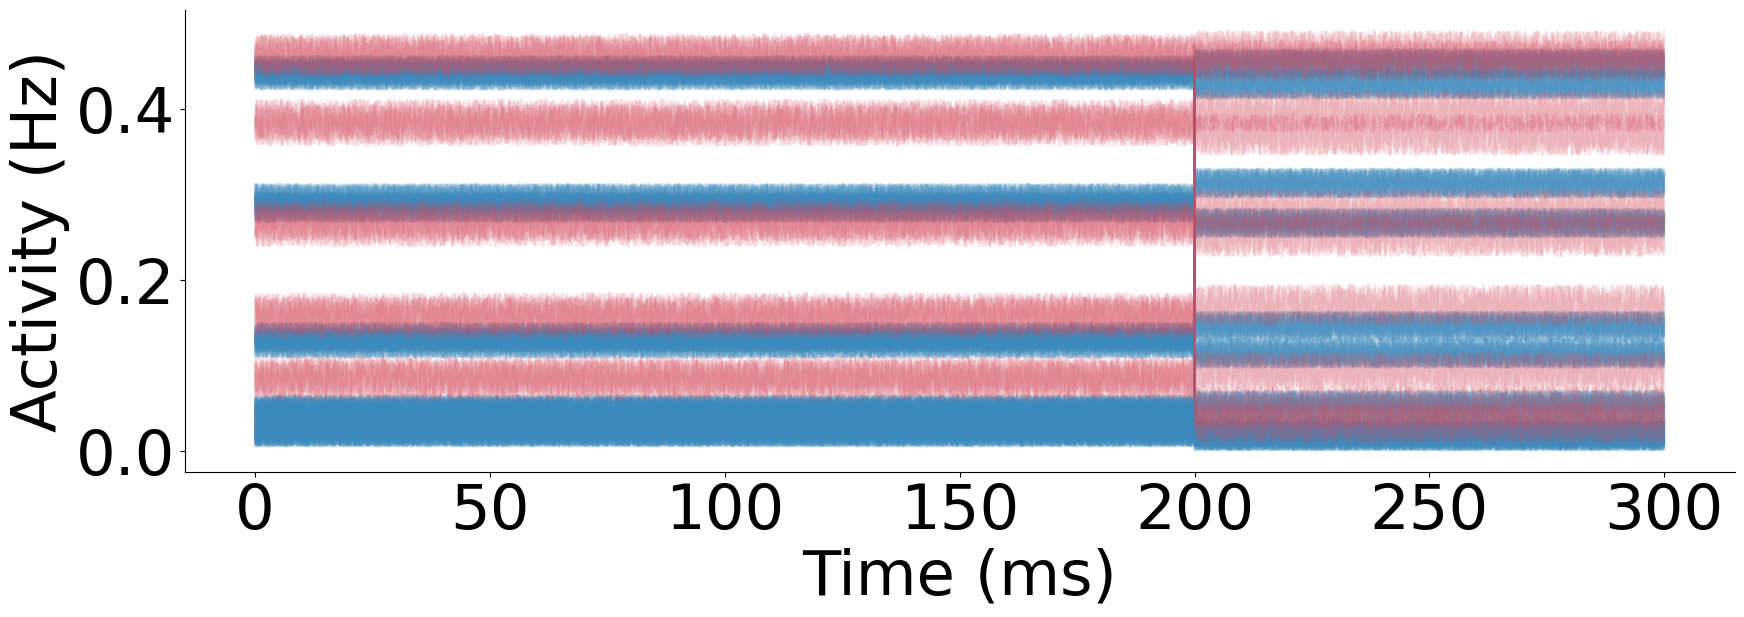

In [15]:
plt.rcParams.update({'font.size': 45})

plt.figure(figsize= (20, 6))
plt.plot(np.linspace(0, 300, 3000), E_currents[0:3000, 0:200], color = '#3d8bbeff', alpha = 0.1);
plt.plot(np.linspace(0, 300, 3000),I_currents[0:3000, 0:50], color = '#d74c5eff', alpha = 0.1);

plt.xlabel('Time (ms)')
plt.ylabel('Activity (Hz)')

sns.despine()

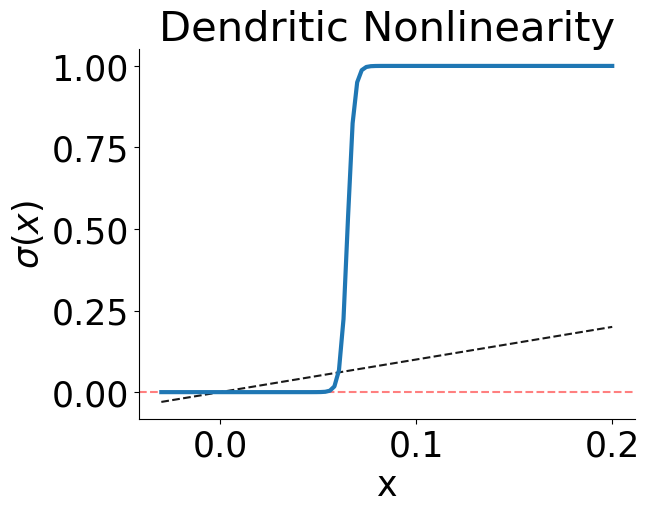

In [9]:
# I DONT NEED THE DENDRITIC NON-LINEARITY

plt.rcParams.update({'font.size': 25})

nonlinparams = np.array([0.0, 1.0, 1.0, 1.0, -600, 0.065])

x = np.linspace(-0.03, 0.2, 100)

plt.plot(x, x, '--k', alpha = 0.9)
plt.axhline(y = 0, linestyle = '--', color = 'r', alpha = 0.5)

plt.plot(x, non_lin(x, nonlin=True, params=nonlinparams), linewidth = 3)

plt.xlabel('x')
plt.ylabel(r'$\sigma(x)$')
plt.title('Dendritic Nonlinearity')

sns.despine()


In [8]:
#### Simulation ####

@nb.njit
def simulate(params, timesteps=int(time/dt)):

    
    # Excitatory
    # Learning rate excitatory
    eta_e = params[0]
    # Total synaptic weight
    e_target = 5.0
    # Plasticity parameters
    alpha_e = 1.0 # Power of pre-synaptic activity
    beta_e = 0.0 # Power of post-synaptic activity
    gamma_e = 0.0 #
    delta_e = 0.0 # Power of the weights

    # Inhibitory
    # Learning rate inhibitory
    eta_i = params[1]
    # Total synaptic weight inhibitory
    i_target = 1.5
    alpha_i = 1.0 # Power of pre-synaptic activity
    beta_i = 0.0 # Power of post-synaptic activity
    gamma_i = 0.0 
    delta_i = 0.0 # Power of the weights

    
    # initialize rate of postsynaptic neuron
    r = np.zeros(timesteps)
    # initialize voltage of postsynaptic neuron
    #v = np.zeros(timesteps)
    
    # initial values at t = 0 
    r[0] = 0.01
    v = 0.25

    # initialize weights to the specific target 
    w_e = e_target * np.random.rand(timesteps, E_inputs) / E_inputs
    w_i = i_target * np.random.rand(timesteps, I_inputs) / I_inputs

    
    E_target = e_target * np.ones(timesteps)

    # Simulate learning
    for t in range(1, timesteps-1):
        # sum of inputs
        x = (w_e[t] * E_currents[t])@W_dend_E - (w_i[t] * I_currents[t])@W_dend_I + dendrite_leak * v
        # WE ARE NOT USING IT -non-linearity of the dendrite
        # QUESTION: we dont apply any non-linearity to the input?
        inp = np.sum(non_lin(x, nonlin=False, params=nonlinparams))

        
        #delta_v = -v / tau + inp
        delta_v = (-v + inp) / tau
        v = v + dt * delta_v
        
        r[t] = rate(v)

        # STDP
        w_e[t+1] = np.maximum(w_e[t] + eta_e * stdp(E_currents[t], r[t], alpha_e, beta_e, gamma_e, delta_e), 0)
        w_i[t+1] = np.maximum(w_i[t] + eta_i * stdp(I_currents[t], r[t], alpha_i, beta_i, gamma_i, delta_i), 0)

        # Meta-Plasticity
        E_target[t+1] = E_target[t] - 0.25*eta_e*(r[t] - r[0])

        # Normalization
        w_e[t+1] = w_e[t+1] * E_target[t+1] / np.sum(w_e[t+1])
        w_i[t+1] = w_i[t+1] * i_target / np.sum(w_i[t+1])

    return w_e, w_i, r, E_target

In [9]:
params= np.array([0.0001, 0.0002])
w_e, w_i, r, E_target = simulate(params)
# alpha_e, beta_e, gamma_e, delta_e, alpha_i, beta_i, gamma_i, delta_i
#params= np.array([0.0001, 0.0002])
#w_e, w_i, r, E_target = simulate_neuron(e_target, i_target, nonlinparams, E_inputs, I_inputs, E_currents, I_currents, W_dend_E, W_dend_I, dendrite_leak, tau, dt, params, time)

In [11]:
#run_network(params)

In [14]:
get_losses(w_e, w_i)

(0.04945607008277843, 0.024235724474892195, 9.772268542295632e-05)

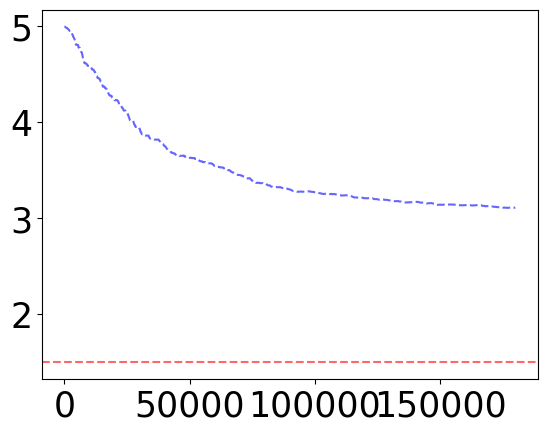

In [10]:
plt.plot(np.linspace(0, time, timesteps), E_target, '--b', alpha = 0.6);
plt.axhline(y = i_target, linestyle ='--', color = 'r', alpha = 0.6);
plt.xlabel('Time (ms)')
plt.ylabel('Synaptic Weight')

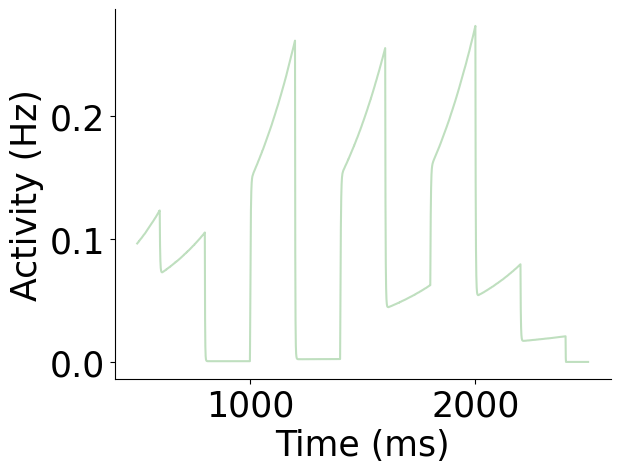

In [11]:
plt.plot(np.linspace(0, time, timesteps-1)[5000:25000], r[5000:25000], color = 'g', alpha = 0.25);
plt.xlabel('Time (ms)')
plt.ylabel('Activity (Hz)')
sns.despine()

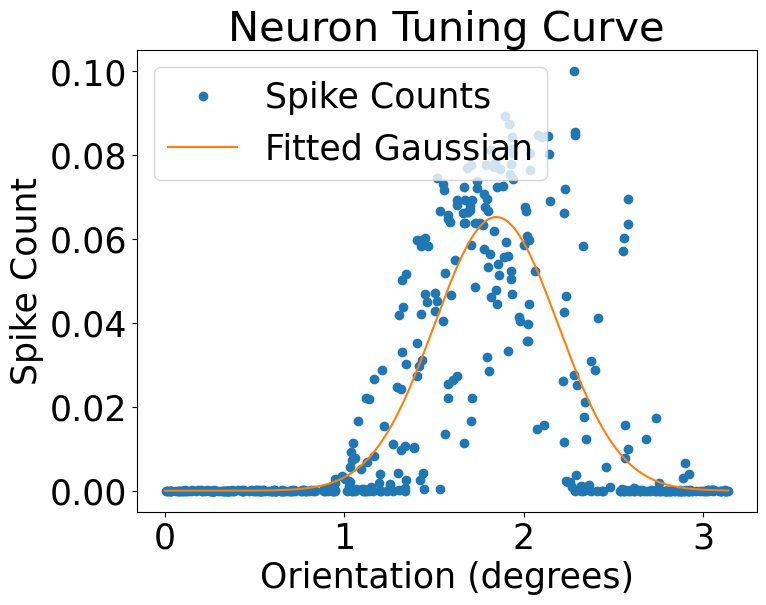

Fitted Parameters: A=0.06525508296237816, mu=1.8468017998486446, sigma=0.345053034044579


In [12]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(- (x - mu)**2 / (2 * sigma**2))

# Take the last half of the data - why?
l = int(len(angle)//2)
x = angle[-l:]
y = np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:]
    

popt, pcov = curve_fit(gaussian, x, y, 
                       maxfev = 150000)
# p0=[0.05, 1.570, 0.3490]
A, mu, sigma = popt

# Generate data using the fitted parameters
x_fit = np.linspace(0, np.pi, 1000)
y_fit = gaussian(x_fit, A, mu, sigma)

plt.figure(figsize=(8, 6))
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:], 'o', label='Spike Counts')
plt.plot(x_fit, y_fit, '-', label='Fitted Gaussian')
# plt.plot(x_fit, y_act, '.', color = 'g')
plt.xlabel('Orientation (degrees)')
plt.ylabel('Spike Count')
plt.title('Neuron Tuning Curve')
plt.legend()
plt.show()

print(f'Fitted Parameters: A={A}, mu={mu}, sigma={sigma}')

In [33]:
x

array([2.32939166, 0.75921399, 0.30198131, 2.24372657, 2.53707778,
       0.92608843, 2.587786  , 2.86098175, 1.06301733, 1.19739625,
       1.8590465 , 1.90128716, 1.56490232, 0.85569484, 1.4454382 ,
       2.72338755, 0.00640896, 0.25761574, 0.18270774, 1.38377561,
       2.18117107, 0.52508759, 0.93951044, 2.54116394, 2.53667657,
       2.66239418, 0.1775938 , 1.87374374, 2.96662075, 0.12292736,
       0.4191042 , 1.38513361, 1.00343175, 1.13982278, 1.85620575,
       0.42565606, 1.77006132, 1.15792495, 1.92272021, 0.88986286,
       2.16287125, 1.87871178, 2.13839377, 2.44373562, 2.91333527,
       1.05359053, 1.70075583, 1.15928504, 2.06147611, 0.42597704,
       2.93678574, 2.81740911, 0.43704422, 0.64549368, 1.02010034,
       2.28999902, 1.00174087, 2.79465656, 1.52289227, 0.13507232,
       0.7405117 , 0.41492872, 2.81472292, 0.72245829, 0.82498928,
       1.43076118, 1.00279839, 1.02499879, 3.06463728, 2.52676744,
       2.87616141, 1.94628991, 1.07881241, 1.93236638, 1.75334

In [18]:
x_fit

array([0.        , 0.00314474, 0.00628947, 0.00943421, 0.01257895,
       0.01572369, 0.01886842, 0.02201316, 0.0251579 , 0.02830264,
       0.03144737, 0.03459211, 0.03773685, 0.04088159, 0.04402632,
       0.04717106, 0.0503158 , 0.05346054, 0.05660527, 0.05975001,
       0.06289475, 0.06603949, 0.06918422, 0.07232896, 0.0754737 ,
       0.07861843, 0.08176317, 0.08490791, 0.08805265, 0.09119738,
       0.09434212, 0.09748686, 0.1006316 , 0.10377633, 0.10692107,
       0.11006581, 0.11321055, 0.11635528, 0.11950002, 0.12264476,
       0.1257895 , 0.12893423, 0.13207897, 0.13522371, 0.13836845,
       0.14151318, 0.14465792, 0.14780266, 0.15094739, 0.15409213,
       0.15723687, 0.16038161, 0.16352634, 0.16667108, 0.16981582,
       0.17296056, 0.17610529, 0.17925003, 0.18239477, 0.18553951,
       0.18868424, 0.19182898, 0.19497372, 0.19811846, 0.20126319,
       0.20440793, 0.20755267, 0.21069741, 0.21384214, 0.21698688,
       0.22013162, 0.22327635, 0.22642109, 0.22956583, 0.23271

In [19]:
popt

array([ 1.85147422e-05,  2.04531849e+00, -1.13981276e-01])

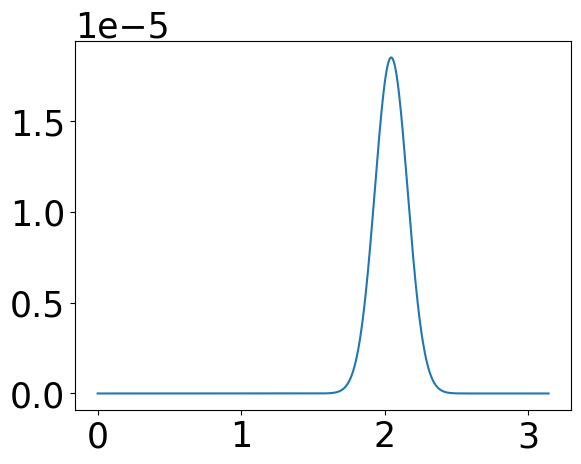

In [29]:
#plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:], 'o', label='Spike Counts')
plt.plot(x_fit, y_fit, '-', label='Fitted Gaussian')
#plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:], 'o', label='Spike Counts')

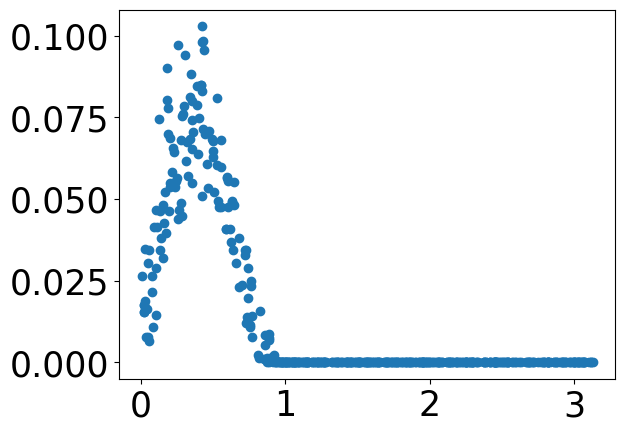

In [25]:
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:], 'o', label='Spike Counts')

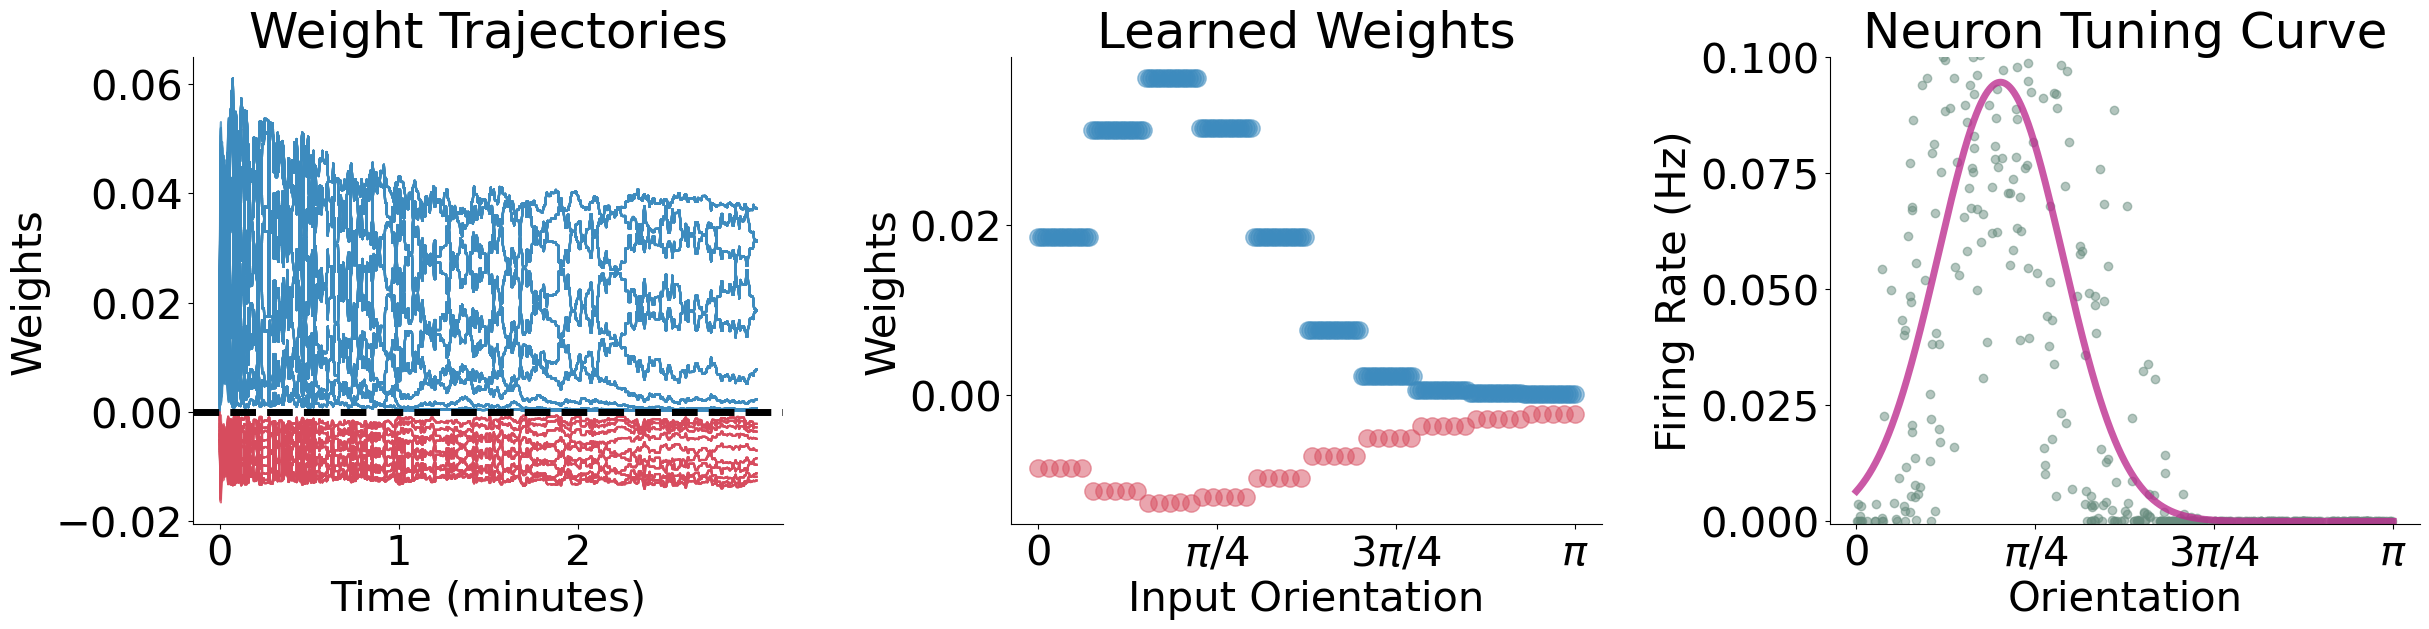

In [14]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize= (25, 7))


plt.subplot(1, 3, 1)
plt.plot(np.linspace(0, time, timesteps)[::2000], w_e[::2000], color = '#3d8bbeff', alpha = 0.8);
plt.plot(np.linspace(0, time, timesteps)[::2000], -w_i[::2000]/4, color = '#d74c5eff', alpha = 0.8);
plt.axhline(y = 0, linestyle = "--", linewidth = 5.0, color = 'k')
plt.xticks([0, 60000, 120000], ['0', '1', '2'])
plt.xlabel('Time (minutes)')
plt.ylabel('Weights')
plt.title('Weight Trajectories')
sns.despine()

plt.subplot(1, 3, 2)
plt.plot(np.linspace(0, 100, E_inputs), w_e[-1], '.', markersize = 25, color = '#3d8bbeff', alpha = 0.5)
plt.plot(np.linspace(0, 100, I_inputs), -w_i[-1]/4, '.', markersize = 25, color = '#d74c5eff', alpha = 0.5)
plt.xlabel('Input Orientation')
plt.xticks(np.linspace(0, 100, 4), ['0', r'$\pi/4$', r'$3\pi/4$', r'$\pi$'])
plt.ylabel('Weights')
plt.title('Learned Weights')


plt.subplot(1, 3, 3)
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:],
         'o',
         label='FR',
         color = '#688c7eca', alpha = 0.5)
plt.plot(x_fit, y_fit, '-', label='Gaussian', color = '#bc2d8fca', linewidth = 5)
plt.xticks(np.linspace(0, np.pi, 4), ['0', r'$\pi/4$', r'$3\pi/4$', r'$\pi$'])
plt.xlabel('Orientation')
plt.ylabel('Firing Rate (Hz)')
plt.title('Neuron Tuning Curve')
plt.ylim([-0.0005, 0.1])
sns.despine()

plt.tight_layout()

In [27]:
X = np.linspace(0, 100, 100)

np.roll(X, 10)

array([ 90.90909091,  91.91919192,  92.92929293,  93.93939394,
        94.94949495,  95.95959596,  96.96969697,  97.97979798,
        98.98989899, 100.        ,   0.        ,   1.01010101,
         2.02020202,   3.03030303,   4.04040404,   5.05050505,
         6.06060606,   7.07070707,   8.08080808,   9.09090909,
        10.1010101 ,  11.11111111,  12.12121212,  13.13131313,
        14.14141414,  15.15151515,  16.16161616,  17.17171717,
        18.18181818,  19.19191919,  20.2020202 ,  21.21212121,
        22.22222222,  23.23232323,  24.24242424,  25.25252525,
        26.26262626,  27.27272727,  28.28282828,  29.29292929,
        30.3030303 ,  31.31313131,  32.32323232,  33.33333333,
        34.34343434,  35.35353535,  36.36363636,  37.37373737,
        38.38383838,  39.39393939,  40.4040404 ,  41.41414141,
        42.42424242,  43.43434343,  44.44444444,  45.45454545,
        46.46464646,  47.47474747,  48.48484848,  49.49494949,
        50.50505051,  51.51515152,  52.52525253,  53.53

In [28]:
from sklearn.metrics import r2_score

# Calculate the R-squared value
r_squared = r2_score(np.mean(r.reshape(-1, int(100/dt)), axis=1)[-l:], gaussian(angle[-l:], *popt))
print(f'R-squared: {r_squared}')

R-squared: -1.270500619182882


In [17]:
def activation(x, y):
    return np.exp(-((x-y)**2)/(2*(np.pi/9)**2))


y_act = A*activation(mu, x_fit)


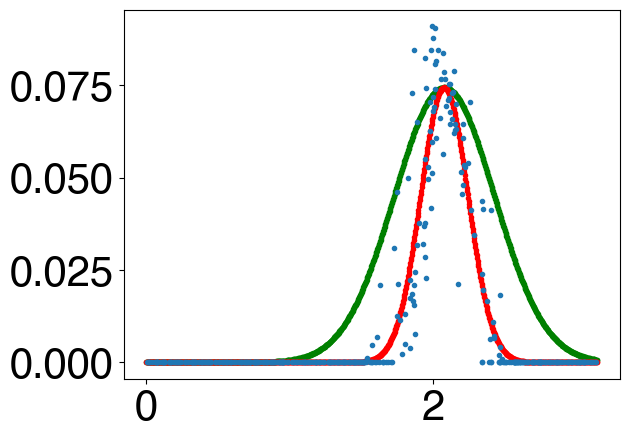

In [18]:
plt.plot(x_fit, y_act, '.', color = 'g')
plt.plot(x_fit, y_fit, '.', color = 'r')
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:], '.')


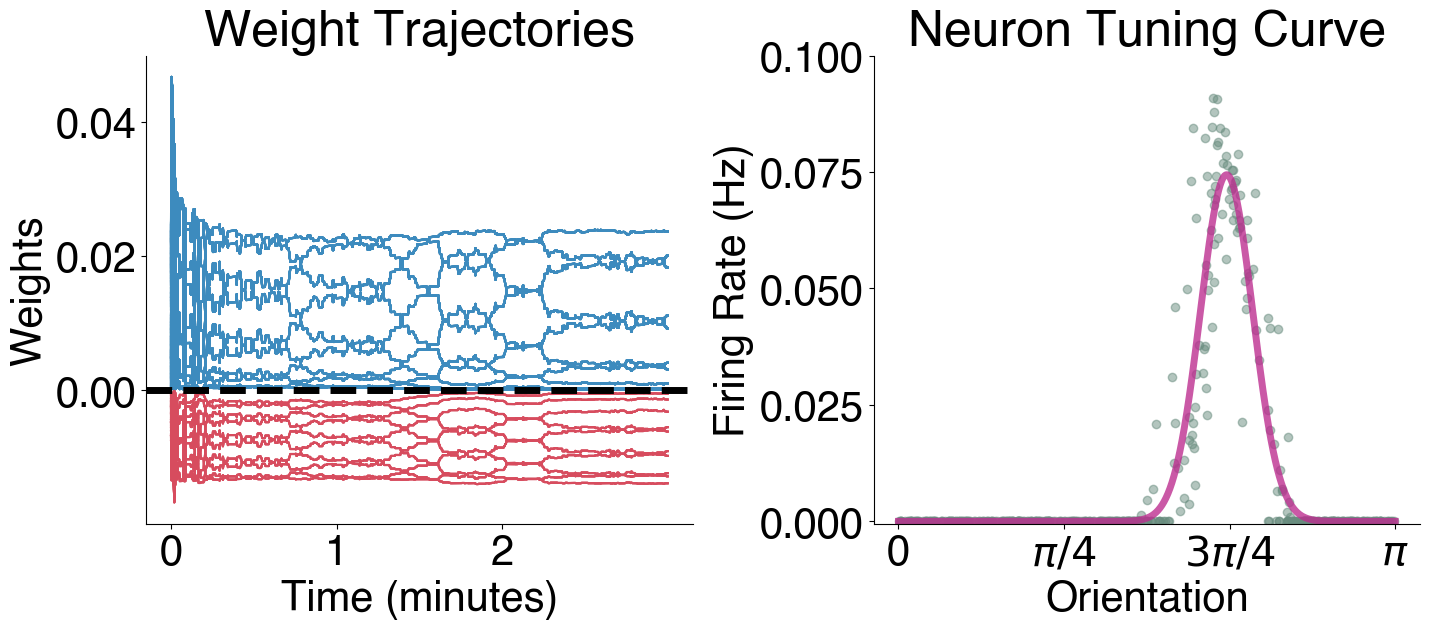

In [19]:
plt.rcParams.update({'font.size': 30})
plt.figure(figsize= (15, 7))


plt.subplot(1, 2, 1)
plt.plot(np.linspace(0, time, timesteps)[::2000], w_e[::2000], color = '#3d8bbeff', alpha = 0.8);
plt.plot(np.linspace(0, time, timesteps)[::2000], -w_i[::2000]/4, color = '#d74c5eff', alpha = 0.8);
plt.axhline(y = 0, linestyle = "--", linewidth = 5.0, color = 'k')
plt.xticks([0, 60000, 120000], ['0', '1', '2'])
plt.xlabel('Time (minutes)')
plt.ylabel('Weights')
plt.title('Weight Trajectories')
sns.despine()

plt.subplot(1, 2, 2)
plt.plot(angle[-l:], np.mean(r.reshape(-1, int(pulse_time/dt)), axis=1)[-l:],
         'o',
         label='FR',
         color = '#688c7eca', alpha = 0.5)
plt.plot(x_fit, y_fit, '-', label='Gaussian', color = '#bc2d8fca', linewidth = 5)
plt.xticks(np.linspace(0, np.pi, 4), ['0', r'$\pi/4$', r'$3\pi/4$', r'$\pi$'])
plt.xlabel('Orientation')
plt.ylabel('Firing Rate (Hz)')
plt.title('Neuron Tuning Curve')
plt.ylim([-0.0005, 0.1])
sns.despine()

plt.tight_layout()